In [1]:
%matplotlib inline
import pandas as pd
import re
import os, itertools, csv
import bleach
import progressbar
from bs4 import BeautifulSoup
from datetime import datetime
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier, VotingClassifier, VotingRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_curve
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('./contest1_data/train.csv')
print(df.head(5))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


## Data Preprocessing

- two model
    - one is title's word2vec
    - one is other features like datachannel, tag or sth (0.57's model)

In [19]:
def data_preprocess(text):
    bs = BeautifulSoup(text, 'html.parser')
    title = bs.find(class_="title").text
    content = bs.find(class_="article-content").text
    channel = bs.find("article")["data-channel"]
#     tag = bs.find(class_="article-topics").text
#     match = re.compile('Topics:')
#     tag = match.sub(r' ', tag)
    topic_tags = bs.find('footer', class_="article-topics").find_all('a')
    topics = [t.get_text() for t in topic_tags]
    tag = ' '.join( topics )
    fig_count = len(bs.find_all('img'))
    link_count = len(bs.find_all('a'))
    
    time = bs.find('time')
    timestamp = np.NaN
    weekday = np.NaN
    ## Dealing with empty value
    if time.has_attr('datetime'):
        time = time['datetime']
        time = datetime.strptime(time, '%a, %d %b %Y %H:%M:%S %z')
        weekday = time.weekday()
        timestamp = time.timestamp()
    
#     time = bs.find('time')['datetime']
#     time = datetime.strptime(time, '%a, %d %b %Y %H:%M:%S %z')
#     weekday = time.weekday()
#     timestamp = time.timestamp()
#     print(title)
#     print(content)
#     print("channel", channel)
#     print("tag",tag)
    return title, content, tag, channel, fig_count, link_count, weekday, timestamp

# data_preprocess(df.loc[0,'Page content'])

In [4]:
# for train data
# df_small = df.sample(n=100, random_state=0)

train_data = pd.DataFrame(columns=["title", "content", "tag", "channel", "fig_count", "link_count", "weekday","timestamp"])
train_label = pd.DataFrame(columns=["Popularity"])
pgbar = progressbar.ProgressBar(widgets=['Progress: ',progressbar.Percentage(), ' ', progressbar.Bar('#'), progressbar.ETA()])
for i in pgbar(range(len(df))):
    title, content, tag, channel,  fig_count, link_count, weekday, timestamp = data_preprocess(df.loc[i,'Page content'])
    train_data = train_data.append({ 
                                    "title": title, 
                                    "content": content,
                                    "tag":  tag,
                                    "channel": channel, 
                                    "fig_count":  fig_count,
                                    "link_count":  link_count,
                                    "weekday":  weekday,
                                    "timestamp":  timestamp
                                    }, ignore_index=True)
    train_label = train_label.append({ "Popularity": df.loc[i, "Popularity"]}, ignore_index=True)
    
train_data.head()


# print(y_train[:,0])
# print(y_train[:,'Popularity'])


Progress: 100% |#################################################|Time: 0:03:42


,title,content,tag,channel,fig_count,link_count,weekday,timestamp
0,NASA's Grand Challenge: Stop Asteroids From De...,There may be killer asteroids headed for Eart...,Asteroid Asteroids challenge Earth Space U.S. ...,world,1,22,2,1.371654e+09
1,Google's New Open Source Patent Pledge: We Won...,Google took a stand of sorts against patent-l...,Apps and Software Google open source opn pledg...,tech,2,18,3,1.364492e+09
2,Ballin': 2014 NFL Draft Picks Get to Choose Th...,You've spend countless hours training to be a...,Entertainment NFL NFL Draft Sports Television,entertainment,2,11,2,1.399490e+09
3,Cameraperson Fails Deliver Slapstick Laughs,Tired of the same old sports fails and ne...,Sports Video Videos Watercooler,watercooler,1,13,4,1.381458e+09
4,NFL Star Helps Young Fan Prove Friendship With...,"At 6-foot-5 and 298 pounds, All-Pro NFL star ...",Entertainment instagram instagram video NFL Sp...,entertainment,52,16,3,1.397706e+09


In [5]:
label_le = LabelEncoder()
train_data["channel"] = label_le.fit_transform(train_data["channel"].values)

X_train, X_test, y_train, y_test = train_test_split(train_data, train_label['Popularity'].astype('int'), test_size=0.2, random_state=0)
# print(X_train)
# print(y_train)
tmp_X = X_train
tmp_y = y_train

## Features Engineering 

In [6]:
nltk.download('stopwords')
stop = stopwords.words('english')

def preprocessor(text):
    # remove HTML tags
#     print("text type = ", type(text))
#     print("text  = ", text)
    text = text[0]
#     print("text  = ", text)
#     text = BeautifulSoup(text, 'html.parser').get_text()
#     text = text.decode('utf-8') 
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip())
            if w not in stop and re.match('[a-zA-Z]+', w)]

[nltk_data] Downloading package stopwords to /home/hhliao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
######################
# custom transformer for sklearn pipeline
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols_from, cols_to):
        self.cols_from = cols_from
        self.cols_to = cols_to

    def transform(self, X):
        col_data = pd.DataFrame()
        col_data = X.iloc[:, self.cols_from:self.cols_to]
#         print("shape = ",col_data.shape)
#         print("data = ",col_data)
        return col_data.values
#     return col_data["feature"]

    def fit(self, X, y=None):
        return self

In [8]:
# tags
pipe_title = Pipeline([
                    ('col_extract', ColumnExtractor( cols_from=0, cols_to=1 )),
                    ('vect', TfidfVectorizer(preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop) ), 
                    ('clf', RandomForestClassifier(n_estimators=400, max_depth=5, n_jobs=-1))
                ])
pipe_content = Pipeline([
                    ('col_extract', ColumnExtractor( cols_from=1, cols_to=2 )),
                    ('vect', TfidfVectorizer(preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop) ), 
                    ('clf', RandomForestClassifier(n_estimators=400, max_depth=5, n_jobs=-1))
                ])
pipe_tag = Pipeline([
                    ('col_extract', ColumnExtractor( cols_from=2, cols_to=3 )),
                    ('vect', TfidfVectorizer(preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop) ), 
                    ('clf', RandomForestClassifier(n_estimators=400, max_depth=5, n_jobs=-1))
                ])
names = ['title','content','tag']
for name, clf in zip(names, [pipe_title, pipe_content, pipe_tag]):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train,
                         cv=10, scoring='roc_auc')
    print('%s: %.3f (+/-%.3f)' % (name, scores.mean(), scores.std()))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    train_data[name] = clf.predict_proba(train_data)
    print('Misclassified samples: %d' % ((y_test != y_pred).sum()))
    print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
  

title: 0.531 (+/-0.012)
Misclassified samples: 2723
Accuracy: 0.5075
content: 0.541 (+/-0.006)
Misclassified samples: 2727
Accuracy: 0.5068
tag: 0.543 (+/-0.012)
Misclassified samples: 2694
Accuracy: 0.5128


In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label['Popularity'].astype('int'), test_size=0.2, random_state=0)


[=======testing different model========]
[auc (10-fold cv)]


[classfier = pipe1]
Misclassified samples: 2637
Accuracy: 0.5231
scores: 0.824 (+/-0.012)
Test AUC: 0.5378


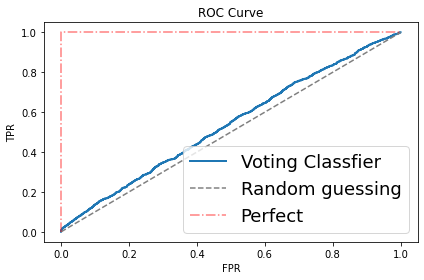



[classfier = pipe2]
Misclassified samples: 2651
Accuracy: 0.5205
scores: 0.822 (+/-0.013)
Test AUC: 0.5378


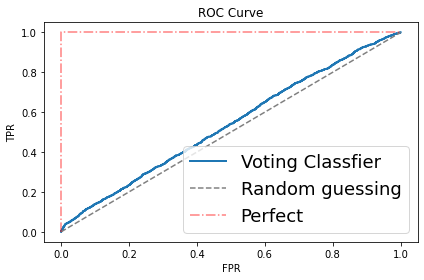



[classfier = pipe3]
Misclassified samples: 2650
Accuracy: 0.5207
scores: 0.772 (+/-0.014)
Test AUC: 0.5346


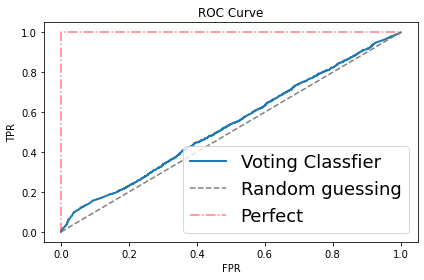



[classfier = pipe4]
Misclassified samples: 2633
Accuracy: 0.5238
scores: 0.821 (+/-0.013)
Test AUC: 0.5371


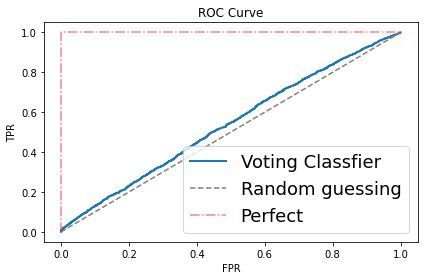



[classfier = pipe5]
Misclassified samples: 2638
Accuracy: 0.5229
scores: 0.823 (+/-0.012)
Test AUC: 0.5391


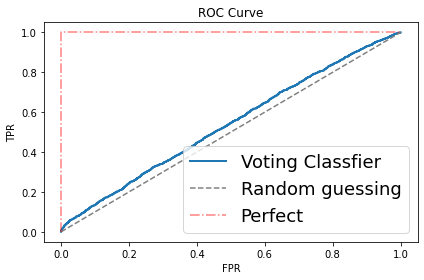



[classfier = pipe6]
Misclassified samples: 2644
Accuracy: 0.5218
scores: 0.823 (+/-0.012)
Test AUC: 0.5387


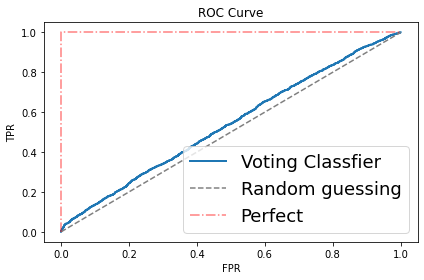

In [13]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
pipe1 = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=500, max_depth=15, n_jobs=-1, random_state=1))
                ])
pipe2 = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=1))
                ])
# channel,fig_count, link_count, weekday
pipe3 = Pipeline([
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=300, max_depth=1, n_jobs=-1, random_state=1))
                ])
pipe4 = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=400, max_depth=25, n_jobs=-1, random_state=1))
                ])
pipe5 = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=800, max_depth=10, n_jobs=-1, random_state=1))
                ])
pipe6 = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=200, max_depth=10, n_jobs=-1, random_state=1))
                ])

print("[=======testing different model========]")

names = ['pipe1','pipe2','pipe3','pipe4','pipe5','pipe6']
print('[auc (10-fold cv)]')
best_clf , best_sc = None, -1
for name, clf in zip(names, [pipe1, pipe2, pipe3, pipe4, pipe5, pipe6]):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train,
                         cv=10, scoring='roc_auc')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test,
                                 prob[:, 1],
                                pos_label=1)
    print("\n\n[classfier = %s]" % name)
    print('Misclassified samples: %d' % ((y_test != y_pred).sum()))
    print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
    print('scores: %.3f (+/-%.3f)' % (scores.mean(), scores.std()))
    print('Test AUC: %.4f' % auc(fpr, tpr))
    

    plt.plot(fpr, tpr, lw=2,
             label='Voting Classfier')

    plt.plot([0, 1],
             [0, 1],
             linestyle='--',
             color='gray',
             label='Random guessing')

    plt.plot([0, 0, 1],
             [0, 1, 1],
             linestyle='-.',
             alpha=0.5,
             color='red',
             label='Perfect')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.legend(loc=4, prop={'size': 18})
    plt.show()
    if best_sc < scores.mean():
        best_clf, best_sc = clf, scores.mean()

Misclassified samples: 2637
Accuracy: 0.5231


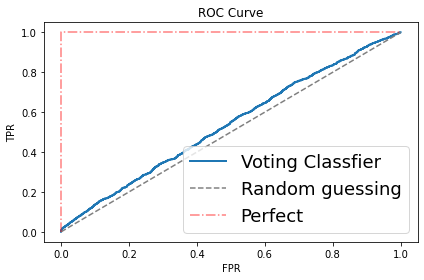

AUC: 0.5378


In [14]:
import matplotlib.pyplot as plt
proba = best_clf.predict_proba(X_test)
y_pred = best_clf.predict(X_test)
print('Misclassified samples: %d' % ((y_test != y_pred).sum()))
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
## we use feature 1 as positive label
fpr, tpr, thresholds = roc_curve(y_test,
                                 proba[:, 1],
                                pos_label=1)

plt.plot(fpr, tpr, lw=2,
         label='Voting Classfier')
    
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color='gray',
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle='-.',
         alpha=0.5,
         color='red',
         label='Perfect')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.legend(loc=4, prop={'size': 18})
plt.show()
print('AUC: %.4f' % auc(fpr, tpr))

In [26]:
df_real = pd.read_csv('./contest1_data/test.csv')

test_data = pd.DataFrame(columns=["title", "content", "tag", "channel", "fig_count", "link_count", "weekday","timestamp"])
pgbar = progressbar.ProgressBar(widgets=['Progress: ',progressbar.Percentage(), ' ', progressbar.Bar('#'), progressbar.ETA()])
for i in pgbar(range(len(df_real))):
    title, content, tag, channel,  fig_count, link_count, weekday, timestamp = data_preprocess(df_real.loc[i,'Page content'])
    test_data = test_data.append({ 
                                    "title": title, 
                                    "content": content,
                                    "tag":  tag,
                                    "channel": channel, 
                                    "fig_count":  fig_count,
                                    "link_count":  link_count,
                                    "weekday":  weekday,
                                    "timestamp":  timestamp
                                    }, ignore_index=True)
    
test_data.head()
label_le = LabelEncoder()
test_data["channel"] = label_le.fit_transform(test_data["channel"].values)


Progress: 100% |#################################################|Time: 0:01:10


In [27]:
# test_data = test_data[:]
# print( test_data)
names = ['title','content','tag']
for name, clf in zip(names, [pipe_title, pipe_content, pipe_tag]):
#     scores = cross_val_score(estimator=clf, X=X_train, y=y_train,
#                          cv=10, scoring='roc_auc')
#     print('%s: %.3f (+/-%.3f)' % (name, scores.mean(), scores.std()))
    clf.fit(tmp_X, tmp_y)
#     y_pred = clf.predict(X_test)
    test_data[name] = clf.predict_proba(test_data)
#     print('Misclassified samples: %d' % ((y_test != y_pred).sum()))
#     print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))



In [28]:
result = best_clf.predict_proba(test_data)
out = pd.DataFrame({ 'Id': df_real.Id,'Popularity': result[:, 1]})
out.to_csv('./pred.csv', index=False)

In [ ]:
# proba = pipe2.predict_proba(X_test)
# ## we use feature 1 as positive label
# fpr, tpr, thresholds = roc_curve(y_test,
#                                  proba[:, 1],
#                                 pos_label=1)

# plt.plot(fpr, tpr, lw=2,
#          label='Voting Classfier')
    
# plt.plot([0, 1],
#          [0, 1],
#          linestyle='--',
#          color='gray',
#          label='Random guessing')

# plt.plot([0, 0, 1],
#          [0, 1, 1],
#          linestyle='-.',
#          alpha=0.5,
#          color='red',
#          label='Perfect')

# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('FPR')
# plt.ylabel('TPR')
# plt.title('ROC Curve')
# plt.legend(loc="lower right")
# plt.tight_layout()
# plt.legend(loc=4, prop={'size': 18})
# plt.show()
# print('AUC: %.4f' % auc(fpr, tpr))